In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras import layers
from keras import Model
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

#Get rid of SettingWithCopyWarnings
pd.options.mode.chained_assignment = None  


In [5]:
roseObs = pd.read_csv("../../Data/processedData/Roses/roseObs")
labeledRoseObs = roseObs.dropna()
labeledRoseObs["isFlowering"] = labeledRoseObs['reproductiveCondition'].isin(['flowering','flowering|fruiting','flowering|fruiting|flower budding','flowering|flower budding']).astype(str)
numList = []
for link in labeledRoseObs["references"]:
    numList.append(link.split("/")[-1] + '.jpg')

In [6]:
labeledRoseObs["observationNumber"] = numList
photos = labeledRoseObs[["observationNumber", "isFlowering"]].iloc[0:4000].reset_index(drop=True)


photoPath = "../Data/photos/roses/all"
photos_train, photos_val = train_test_split(list(photos.index), test_size=.2)
p_train= photos.iloc[photos_train]
p_val = photos.iloc[photos_val]

In [7]:
#We follow the general structure outlined in Google's Developer Guides for CV with Convolutional Neural Networks

# Our input feature map is 75x75x3: 75x75 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(75, 75, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512  nodes
x = layers.Dense(512, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

model = Model(img_input, output)

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])

In [8]:
# All images will be rescaled by 1./255
datagen=ImageDataGenerator(rescale=1./255.)

# Flow training images in batches of 20 using train_datagen generator
#LOOK AT FLOW_FROM_DATAFRAME
train_generator = datagen.flow_from_dataframe(
        p_train,
        directory=photoPath,
        x_col="observationNumber",
        y_col="isFlowering",
        target_size=(75, 75),  # All images will be resized to 75x75
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator_df = datagen.flow_from_dataframe(
        p_val,
        directory=photoPath,
        x_col="observationNumber",
        y_col="isFlowering",
        target_size=(75, 75),  # All images will be resized to 75x75
        batch_size=20,
        shuffle=False,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 3200 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.


In [9]:
history = model.fit(
      train_generator,
      steps_per_epoch=160,  
      epochs=15,
      validation_data=validation_generator_df,
      validation_steps=40, 
      verbose=1)

Epoch 1/15


160/160 [==============================] - 6s 30ms/step - loss: 0.5330 - acc: 0.7284 - val_loss: 0.3913 - val_acc: 0.8300
Epoch 2/15
160/160 [==============================] - 3s 19ms/step - loss: 0.3697 - acc: 0.8456 - val_loss: 0.4242 - val_acc: 0.8150
Epoch 3/15
160/160 [==============================] - 3s 19ms/step - loss: 0.3066 - acc: 0.8791 - val_loss: 0.3903 - val_acc: 0.8450
Epoch 4/15
160/160 [==============================] - 3s 21ms/step - loss: 0.2697 - acc: 0.8944 - val_loss: 0.2959 - val_acc: 0.8950
Epoch 5/15
160/160 [==============================] - 3s 19ms/step - loss: 0.2453 - acc: 0.9081 - val_loss: 0.2910 - val_acc: 0.8925
Epoch 6/15
160/160 [==============================] - 3s 19ms/step - loss: 0.2182 - acc: 0.9137 - val_loss: 0.2854 - val_acc: 0.9025
Epoch 7/15
160/160 [==============================] - 3s 19ms/step - loss: 0.1956 - acc: 0.9306 - val_loss: 0.3268 - val_acc: 0.8988
Epoch 8/15
160/160 [==============================] - 3s 19ms/step 

Text(0.5, 1.0, 'CNN Train/Validation Loss')

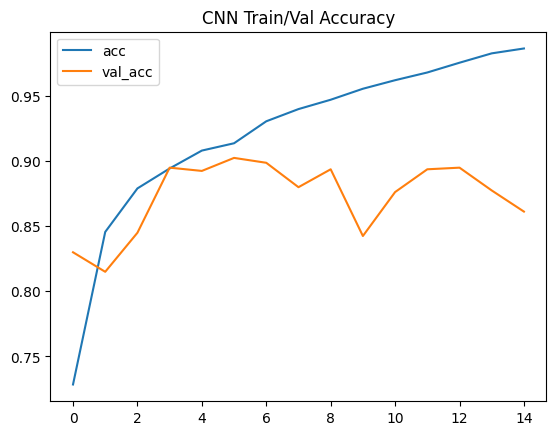

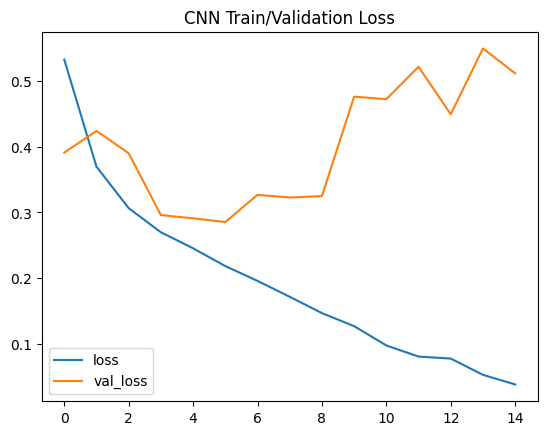

In [10]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label="acc")
plt.plot(epochs, val_acc, label="val_acc")
plt.title('CNN Train/Val Accuracy')
plt.legend()
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label="loss")
plt.plot(epochs, val_loss, label="val_loss")
plt.legend()
plt.title('CNN Train/Validation Loss')

It looks like there is some non-trivial overfitting. Now we'll train with an additional augmentation of our training data as well as some dropout

In [11]:
#Reset our model

img_input = layers.Input(shape=(75, 75, 3))


x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)


x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)


x = layers.Convolution2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Flatten()(x)

x = layers.Dense(512, activation='relu')(x)

x = layers.Dropout(0.5)(x)

output = layers.Dense(1, activation='sigmoid')(x)

model = Model(img_input, output)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])

In [12]:
#Data augmentation
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, 
    fill_mode='nearest')


# Do not augment the validation set
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        p_train,
        directory=photoPath,
        x_col="observationNumber",
        y_col="isFlowering",
        target_size=(75, 75),  
        batch_size=20,
        class_mode='binary')

validation_generator = val_datagen.flow_from_dataframe(
        p_val,
        directory=photoPath,
        x_col="observationNumber",
        y_col="isFlowering",
        target_size=(75, 75),
        batch_size=20,
        shuffle=False,
        class_mode='binary')


history = model.fit(
      train_generator,
      steps_per_epoch=160,  # 3200 images = batch_size * steps
      epochs=30,
      validation_data=validation_generator,
      validation_steps=40,  # 800 images = batch_size * steps
      verbose=2)

Found 3200 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.
Epoch 1/30
160/160 - 7s - loss: 0.5867 - acc: 0.6809 - val_loss: 0.4834 - val_acc: 0.7175 - 7s/epoch - 41ms/step
Epoch 2/30
160/160 - 6s - loss: 0.4298 - acc: 0.8100 - val_loss: 0.3697 - val_acc: 0.8625 - 6s/epoch - 37ms/step
Epoch 3/30
160/160 - 6s - loss: 0.3480 - acc: 0.8578 - val_loss: 0.3780 - val_acc: 0.8487 - 6s/epoch - 37ms/step
Epoch 4/30
160/160 - 6s - loss: 0.3176 - acc: 0.8741 - val_loss: 0.3088 - val_acc: 0.8813 - 6s/epoch - 36ms/step
Epoch 5/30
160/160 - 6s - loss: 0.3081 - acc: 0.8731 - val_loss: 0.2904 - val_acc: 0.8900 - 6s/epoch - 36ms/step
Epoch 6/30
160/160 - 6s - loss: 0.2871 - acc: 0.8856 - val_loss: 0.3598 - val_acc: 0.8750 - 6s/epoch - 36ms/step
Epoch 7/30
160/160 - 6s - loss: 0.2887 - acc: 0.8906 - val_loss: 0.2880 - val_acc: 0.9013 - 6s/epoch - 36ms/step
Epoch 8/30
160/160 - 6s - loss: 0.2677 - acc: 0.8969 - val_loss: 0.3236 - val_acc: 0.886

Text(0.5, 1.0, 'CNN Loss with Image Augmentation')

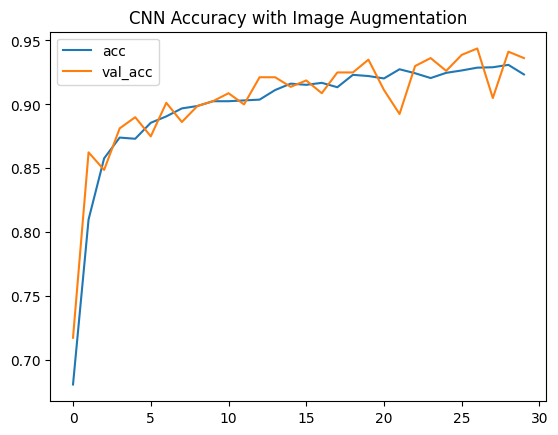

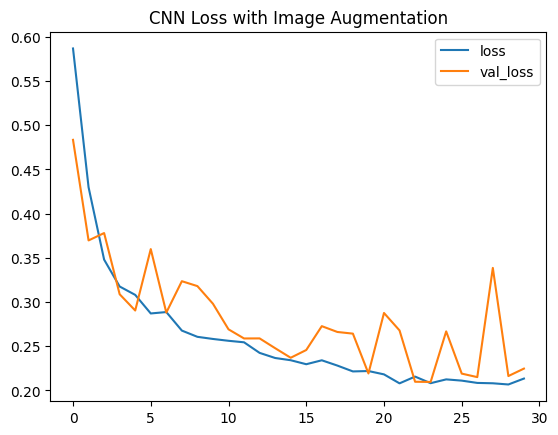

In [13]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label="acc")
plt.plot(epochs, val_acc, label="val_acc")
plt.title('CNN Accuracy with Image Augmentation')
plt.legend()
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label="loss")
plt.plot(epochs, val_loss, label="val_loss")
plt.legend()
plt.title('CNN Loss with Image Augmentation')

We see that our model can reach a generalization accuracy of around 91% percent. 

In [14]:
model.save('../../Models/Roses/roseModel.keras')